In [1]:
from models.resnet import *
from Stack_LIME import *
from coordconv import *

import glob

from IPython.display import clear_output

from pytorch_lightning import LightningModule, Trainer

import torch
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split

import torchvision
from torchvision import transforms
from torchvision.datasets import CIFAR10

import torchmetrics

torch.manual_seed(17)
tf = transforms.ToPILImage()

In [2]:
def create_folder(name):
    try:
        if not os.path.exists(name):
            os.makedirs(name)
    except OSError:
        print ('Error: Creating directory. ' + name)

In [3]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

In [4]:
class CNN(LightningModule):
    def __init__(self, batch_size = 200, num_workers = 0, train_dataset = None,
    test_dataset = None):
        super().__init__()
        self.model = resnet50(pretrained=False, progress=True, device="cuda")
#         self.model = torchvision.models.squeezenet1_1()
#         self.model.features[0] = nn.Sequential(CoordConv2d(3, 32, 1, with_r=True),nn.Conv2d(32,64,3))
#         self.model.classifier[1] = nn.Conv2d(512, 10, 1, 1)
        self.num_workers = num_workers
        self.batch_size = batch_size
        self.train_dataset = train_dataset
        self.test_dataset = test_dataset
        self.metrics = torchmetrics.Accuracy()
        
    def restart(self, batch_size = 200, num_workers = 0, train_dataset = None,test_dataset = None):
        self.num_workers = num_workers
        self.batch_size = batch_size
        self.train_dataset = train_dataset
        self.test_dataset = test_dataset
        self.metrics = torchmetrics.Accuracy()
        
    def forward(self, x):
        x = self.model(x)
        return x

    def training_step(self, batch, batch_nb):
        x, y = batch
        loss = F.cross_entropy(self(x), y)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = self.metrics(logits, y)
        metrics = {"val_acc": acc, "val_loss": loss}
        self.log_dict(metrics)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        x=x.to('cpu')
        img = np.array(x)
        
#         print('img shape:',img.shape)
#         print('y shape:', y.shape)
#         print('y[0]:', y[0])
#         print('#################################')
        
        batch_size, channel, width,height = img.shape
        half_width = int(width/2)
        half_height = int(height/2)
        loss = 0
        acc = 0
        for i in range(batch_size):
            img_list_4 = [img[i, :, :half_width, :half_height],
                    img[i, :, half_width:, :half_height],
                    img[i, :, :half_width, half_height:],
                    img[i, :, half_width:, half_height:]]
            img_list_4 = torch.tensor(img_list_4)
            img_list_4 = img_list_4.to('cuda')

            loss_l = 0
            acc_l = torch.tensor([[0. for i in range(10)]])
            acc_l = acc_l.to('cuda')
            for j in range(len(img_list_4)):
                # print('img shape:', img_l.shape)
                
                # print('gt:',y[i].unsqueeze(0))
                logits = self(img_list_4[j].unsqueeze(0))
                #print('logits:',logits)
                # print('pred:',logits.shape)
                loss_l += F.cross_entropy(logits, y[i].unsqueeze(0))
                acc_l += logits
                #print('acc:',acc_l)
            loss += loss_l / 4
            acc += self.metrics(acc_l/4, y[i].unsqueeze(0))
        loss /= batch_size
        acc /= batch_size
#         logits = self(x)
#         loss = F.cross_entropy(logits, y)
#         acc = self.metrics(logits, y)
        metrics = {"test_acc": acc, "test_loss": loss}
        self.log_dict(metrics)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.1)

    def setup(self, stage = None):
        if stage == 'fit' or stage is None:
            dataset = self.train_dataset
            dataset_size = dataset.__len__()
            self.train_ds, self.val_ds = random_split(dataset, [int(dataset_size * 0.9) , int(dataset_size * 0.1)])


        if stage == 'test' or stage is None:
            self.test_ds = self.test_dataset

    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=self.batch_size, num_workers = self.num_workers, pin_memory=True)

    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size=self.batch_size, num_workers = self.num_workers, pin_memory=True)

    def test_dataloader(self):
        return DataLoader(self.test_ds, batch_size=self.batch_size, num_workers = self.num_workers, pin_memory=True)

In [23]:
class CIFAR10_edit(Dataset):
    def __init__(self, img_dir, labels, transform = None):
        self.img_dir = img_dir
        self.img_labels = glob.glob(img_dir+'/*')
        self.img = []
        for k in self.img_labels:
            imgs = glob.glob(k + '/*')
            self.img += imgs
        self.transform = transform
        self.labels = labels

    def __len__(self):
        return len(self.img)

    def __getitem__(self, idx):
        img_path = self.img[idx]
        
        image = Image.open(img_path)
        image = np.array(image)

        label = img_path.split('/')
        print(label)
        label = label[2].split('\\')[1]
        label = self.labels.index(label)
        
        if self.transform:
            image = self.transform(image)
        
        return image, label


In [25]:
transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((32,32)),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
    ])
unorm = UnNormalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))

In [38]:
labels = ['airplane', 'automobile', 'bird','cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

train_data = CIFAR10_edit('./data/edit_img_b', labels = labels, transform = transform)
#train_data = CIFAR10('./data/cifar10', train = True, download = False, transform = transform)
test_data = CIFAR10('./data/cifar10', train = False, download = False, transform = transform)

In [27]:
model = CNN(batch_size = 512, num_workers = 0 ,
            train_dataset = train_data, test_dataset = test_data)

In [28]:
chk_path = "./model/resnet50_orig_split.ckpt"
model = model.load_from_checkpoint(chk_path)
model.restart(batch_size = 512, num_workers = 8 ,
            train_dataset = train_data, test_dataset = test_data)

In [10]:
trainer = Trainer(accelerator = 'gpu', devices = 1 , max_epochs = 200)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [28]:
model.setup(None)
trainer.test(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.1023000031709671, 'test_loss': 2010.4176025390625}
--------------------------------------------------------------------------------


[{'test_acc': 0.1023000031709671, 'test_loss': 2010.4176025390625}]

In [ ]:
model.setup('fit')
trainer.validate(model)

In [ ]:
a = torch.tensor([[1,2,3,4,5]])
# a.append(torch.tensor([1,2,3,6,7]))
# a.append(torch.tensor([5,3,4,2,4]))
print(a)
c = torch.stack(a, dim =1)
# c = torch.stack([c,d], dim = 0)
c

In [39]:
stack_xai = Stack_XAI(model, transform)

Model Loaded . . . 
Device is a cuda:0. . . 
transform setting finish . . .
Clear!


c:\users\jh\anaconda3\envs\ispin\lib\site-packages\lime\wrappers\scikit_image.py:117: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  return self.target_fn(args[0], **self.target_params)


['.', 'data', 'edit_img_b\\airplane\\10008.jpg']


100% |########################################################################|


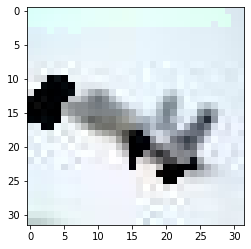

In [40]:
x, y = train_data[0]
x = tf(unorm(x))
t, m = stack_xai.explain(x, XAI = 'LIME', n_seg = 100, n_samples = 100)
plt.imshow(t)

c:\users\jh\anaconda3\envs\ispin\lib\site-packages\lime\wrappers\scikit_image.py:117: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  return self.target_fn(args[0], **self.target_params)


['.', 'data', 'edit_img_b\\airplane\\10010.jpg']


100% |########################################################################|


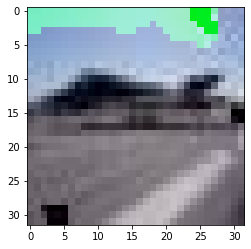

In [41]:
x, y = train_data[1]
x = tf(unorm(x))
t, m = stack_xai.explain(x, XAI = 'LIME', n_seg = 100, n_samples = 100)
plt.imshow(t)

c:\users\jh\anaconda3\envs\ispin\lib\site-packages\lime\wrappers\scikit_image.py:117: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  return self.target_fn(args[0], **self.target_params)


['.', 'data', 'edit_img_b\\airplane\\10020.jpg']


100% |########################################################################|


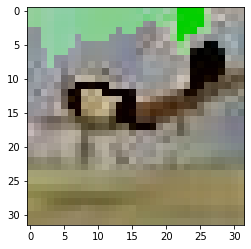

In [42]:
x, y = train_data[2]
x = tf(unorm(x))
t, m = stack_xai.explain(x, XAI = 'LIME', n_seg = 100, n_samples = 100)
plt.imshow(t)

c:\users\jh\anaconda3\envs\ispin\lib\site-packages\lime\wrappers\scikit_image.py:117: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  return self.target_fn(args[0], **self.target_params)


['.', 'data', 'edit_img_b\\airplane\\10024.jpg']


100% |########################################################################|


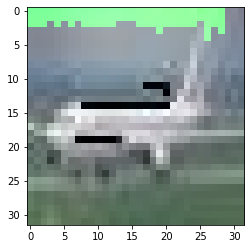

In [43]:
x, y = train_data[3]
x = tf(unorm(x))
t, m = stack_xai.explain(x, XAI = 'LIME', n_seg = 100, n_samples = 100)
plt.imshow(t)